# Predicting with Neural Networks

In [25]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import csv

In [26]:
def plot_series(x,y,format='-',start=0,end=None,title=None,xlabel=None,ylabel=None,legend=None):
    plt.figure(figsize=(10,6))
    if type(y) is tuple:
        for num in y:
            plt.plot(x[start:end],num[start:end],format)
    else:
        plt.plot(x[start:end],y[start:end],format)

    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    if legend:
        plt.legend(legend)
    plt.grid(True)
    plt.show()


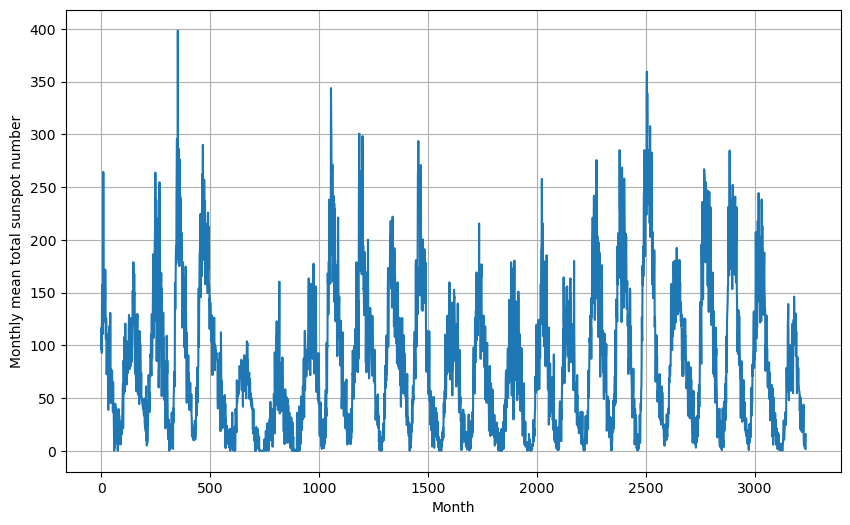

In [27]:
time_step=[]
sunspots=[]
with open('datasets/Sunspots.csv') as file:
    reader=csv.reader(file,delimiter=',')
    next(reader)
    for row in reader:
        time_step.append(int(row[0]))
        sunspots.append(float(row[2]))
time=np.array(time_step)
series=np.array(sunspots)
plot_series(time,series,xlabel='Month',ylabel='Monthly mean total sunspot number')    


In [28]:
split_time=3000
time_train=time[:split_time]
x_train=series[:split_time]
time_valid=time[split_time:]
x_valid=series[split_time:]

In [29]:
def windowed_dataset(series,window_size,batch_size,shuffle_buffer):
    dataset=tf.data.Dataset.from_tensor_slices(series)
    dataset=dataset.window(window_size+1,shift=1,drop_remainder=True)
    dataset=dataset.flat_map(lambda window: window.batch(window_size+1))
    dataset=dataset.map(lambda window: (window[:-1],window[-1]))
    dataset=dataset.shuffle(shuffle_buffer)
    dataset=dataset.batch(batch_size).prefetch(1)
    return dataset

In [30]:
window_size=30
batch_size=33
shuffle_buffer_size=1000
train_set=windowed_dataset(x_train,window_size,batch_size,shuffle_buffer_size)

In [31]:
model=tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(filters=64,kernel_size=3,strides=1,activation='relu',padding='causal',input_shape=[window_size,1]),
    tf.keras.layers.LSTM(64, return_sequences=True),
    tf.keras.layers.LSTM(64),
    tf.keras.layers.Dense(30,activation='relu'),
    tf.keras.layers.Dense(10,activation='relu'),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x:x*400)
])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_3 (Conv1D)           (None, 30, 64)            256       
                                                                 
 lstm_4 (LSTM)               (None, 30, 64)            33024     
                                                                 
 lstm_5 (LSTM)               (None, 64)                33024     
                                                                 
 dense_6 (Dense)             (None, 30)                1950      
                                                                 
 dense_7 (Dense)             (None, 10)                310       
                                                                 
 dense_8 (Dense)             (None, 1)                 11        
                                                                 
 lambda_2 (Lambda)           (None, 1)                

In [32]:
init_weights=model.get_weights()

In [33]:
lr_schedule=tf.keras.callbacks.LearningRateScheduler(
    lambda epoch:1e-8*10**(epoch/20)
)

optimizer=tf.keras.optimizers.SGD(momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),optimizer=optimizer)
history=model.fit(train_set,epochs=100,callbacks=[lr_schedule])

Epoch 1/100
90/90 [==============================] - 3s 11ms/step - loss: 50.4256 - lr: 1.0000e-08
Epoch 2/100
90/90 [==============================] - 1s 9ms/step - loss: 41.0993 - lr: 1.1220e-08
Epoch 3/100
90/90 [==============================] - 1s 9ms/step - loss: 38.9910 - lr: 1.2589e-08
Epoch 4/100
90/90 [==============================] - 1s 9ms/step - loss: 36.8436 - lr: 1.4125e-08
Epoch 5/100
90/90 [==============================] - 1s 9ms/step - loss: 35.0699 - lr: 1.5849e-08
Epoch 6/100
90/90 [==============================] - 1s 10ms/step - loss: 33.3278 - lr: 1.7783e-08
Epoch 7/100
90/90 [==============================] - 1s 9ms/step - loss: 32.0069 - lr: 1.9953e-08
Epoch 8/100
90/90 [==============================] - 1s 10ms/step - loss: 30.4825 - lr: 2.2387e-08
Epoch 9/100
90/90 [==============================] - 1s 9ms/step - loss: 29.2477 - lr: 2.5119e-08
Epoch 10/100
90/90 [==============================] - 1s 11ms/step - loss: 28.2097 - lr: 2.8184e-08
Epoch 11/100
90

(1e-08, 0.001, 0.0, 100.0)

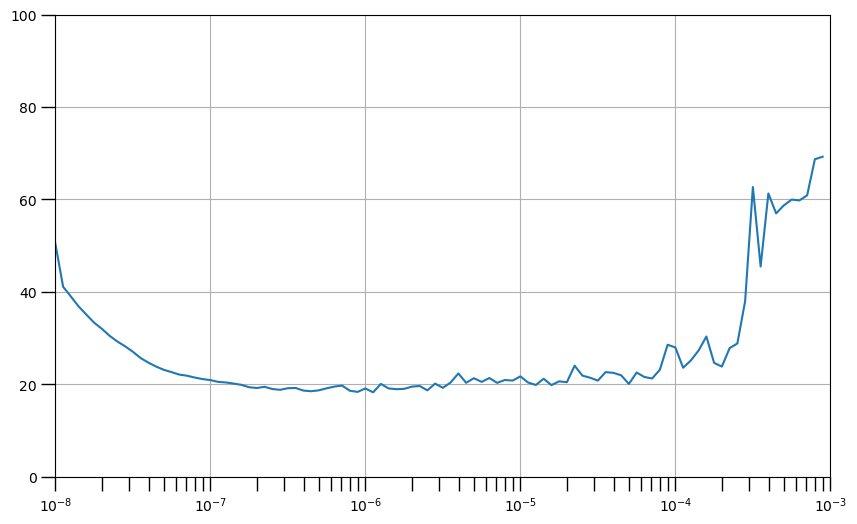

In [34]:
lrs=1e-8*(10**(np.arange(100)/20))
plt.figure(figsize=(10,6))
plt.grid(True)
plt.semilogx(lrs,history.history['loss'])
plt.tick_params('both',length=10,width=1,which='both')
plt.axis([1e-8,1e-3,0,100])

In [37]:
tf.keras.backend.clear_session()
model.set_weights(init_weights)
learning_rate=8e-7
optimizer=tf.keras.optimizers.SGD(learning_rate=learning_rate,momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),optimizer=optimizer,metrics=['mae'])

In [38]:
history=model.fit(train_set,epochs=100)

Epoch 1/100
90/90 [==============================] - 3s 11ms/step - loss: 28.0231 - mae: 28.5185
Epoch 2/100
90/90 [==============================] - 1s 10ms/step - loss: 20.9937 - mae: 21.4884
Epoch 3/100
90/90 [==============================] - 1s 9ms/step - loss: 20.4300 - mae: 20.9239
Epoch 4/100
90/90 [==============================] - 1s 9ms/step - loss: 19.7593 - mae: 20.2518
Epoch 5/100
90/90 [==============================] - 1s 9ms/step - loss: 19.2736 - mae: 19.7673
Epoch 6/100
90/90 [==============================] - 1s 9ms/step - loss: 19.1053 - mae: 19.5983
Epoch 7/100
90/90 [==============================] - 1s 9ms/step - loss: 18.7786 - mae: 19.2713
Epoch 8/100
90/90 [==============================] - 1s 9ms/step - loss: 18.9182 - mae: 19.4106
Epoch 9/100
90/90 [==============================] - 1s 9ms/step - loss: 18.5317 - mae: 19.0221
Epoch 10/100
90/90 [==============================] - 1s 9ms/step - loss: 18.7684 - mae: 19.2600
Epoch 11/100
90/90 [=================

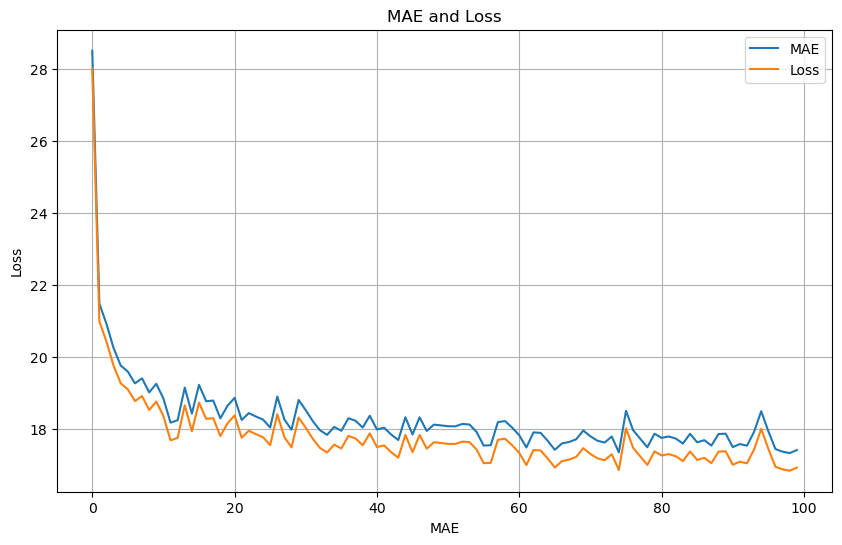

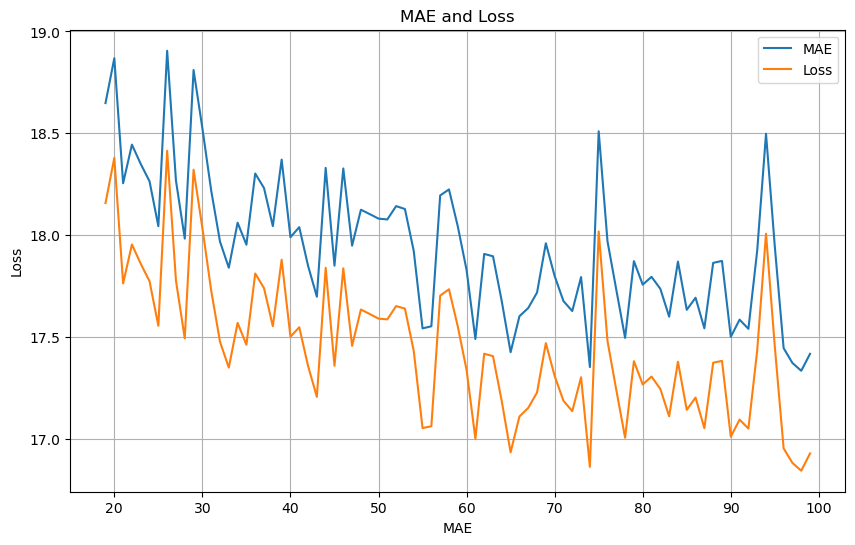

In [40]:
mae=history.history['mae']
loss=history.history['loss']
epochs=range(len(loss))

plot_series(
    x=epochs,
    y=(mae,loss),
    title='MAE and Loss', 
    xlabel='MAE',
    ylabel='Loss',
    legend=['MAE', 'Loss']
)
zoom_split = int(epochs[-1] * 0.2)
epochs_zoom = epochs[zoom_split:]
mae_zoom = mae[zoom_split:]
loss_zoom = loss[zoom_split:]

# Plot zoomed mae and loss
plot_series(
    x=epochs_zoom, 
    y=(mae_zoom, loss_zoom), 
    title='MAE and Loss', 
    xlabel='MAE',
    ylabel='Loss',
    legend=['MAE', 'Loss']
    )

In [42]:
# model prediction

def model_forecast(model,series,window_size,batch_size):
    dataset=tf.data.Dataset.from_tensor_slices(series)
    dataset=dataset.window(window_size,shift=1,drop_remainder=True)
    dataset=dataset.flat_map(lambda window:window.batch(window_size))
    dataset=dataset.batch(batch_size).prefetch(1)
    forecast=model.predict(dataset)
    return forecast

8/8 [==============================] - 0s 7ms/step


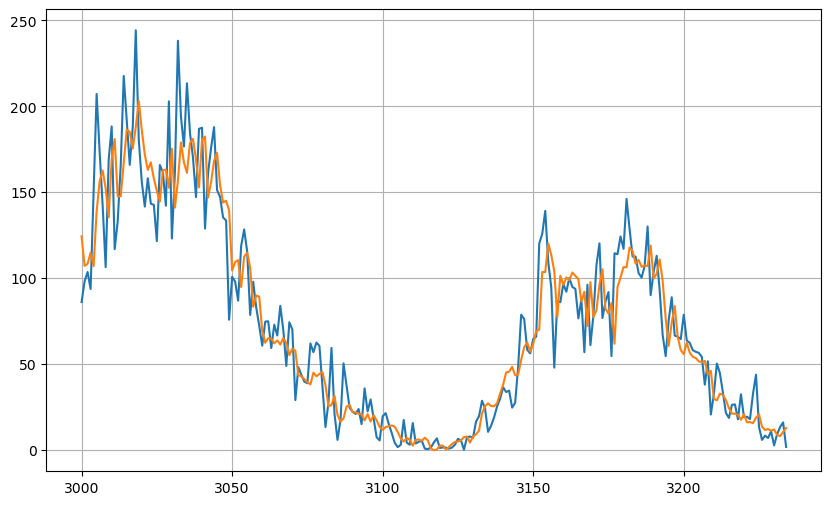

In [45]:
forecast_series=series[split_time-window_size:-1]
forecast=model_forecast(model,forecast_series,window_size,batch_size)
result=forecast.squeeze()
plot_series(time_valid,(x_valid,result))

In [47]:
print(tf.keras.metrics.mean_absolute_error(x_valid, result).numpy())

14.324738


In [48]:
# dynamicall set the learning rate
optimizer=tf.keras.optimizers.SGD(learning_rate=1e-7,momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer,metrics=['mae'])
history=model.fit(train_set,epochs=10)

Epoch 1/10
90/90 [==============================] - 4s 10ms/step - loss: 16.6145 - mae: 17.1057
Epoch 2/10
90/90 [==============================] - 1s 9ms/step - loss: 16.5262 - mae: 17.0163
Epoch 3/10
90/90 [==============================] - 1s 9ms/step - loss: 16.5345 - mae: 17.0254
Epoch 4/10
90/90 [==============================] - 1s 9ms/step - loss: 16.5480 - mae: 17.0388
Epoch 5/10
90/90 [==============================] - 1s 9ms/step - loss: 16.5617 - mae: 17.0527
Epoch 6/10
90/90 [==============================] - 1s 9ms/step - loss: 16.5132 - mae: 17.0040
Epoch 7/10
90/90 [==============================] - 1s 9ms/step - loss: 16.5428 - mae: 17.0328
Epoch 8/10
90/90 [==============================] - 1s 10ms/step - loss: 16.4849 - mae: 16.9748
Epoch 9/10
90/90 [==============================] - 1s 9ms/step - loss: 16.5701 - mae: 17.0601
Epoch 10/10
90/90 [==============================] - 1s 10ms/step - loss: 16.5149 - mae: 17.0052


At some point, the static learning rate you set might no longer be the optimal one when the model has been learning for some time. You may want to decrease it some more to see better improvements. One way to do that is to have your training loop gradually decay the learning rate per epoch. You can pass in a lambda function similar like the one you did for the learning rate scheduler earlier, or use ExponentialDecay(). This is a built in scheduler from the Keras API. This decays the learning rate defined by this function:

In [49]:
def decayed_learning_rate(step):
    return initial_learning_rate*decay_rate^(step/decay_steps)

In [50]:
initial_learning_rate=1e-7
lr_schedule=tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=400,
    decay_rate=0.96,
    staircase=True
)

optimizer = tf.keras.optimizers.SGD(learning_rate=lr_schedule, momentum=0.9)

# Set the training parameters
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

# Train the model
history = model.fit(train_set,epochs=40)

Epoch 1/40
90/90 [==============================] - 3s 11ms/step - loss: 16.6172 - mae: 17.1085
Epoch 2/40
90/90 [==============================] - 1s 9ms/step - loss: 16.4746 - mae: 16.9656
Epoch 3/40
90/90 [==============================] - 1s 9ms/step - loss: 16.5214 - mae: 17.0113
Epoch 4/40
90/90 [==============================] - 1s 10ms/step - loss: 16.5501 - mae: 17.0422
Epoch 5/40
90/90 [==============================] - 1s 10ms/step - loss: 16.5409 - mae: 17.0314
Epoch 6/40
90/90 [==============================] - 1s 9ms/step - loss: 16.4802 - mae: 16.9705
Epoch 7/40
90/90 [==============================] - 1s 9ms/step - loss: 16.4735 - mae: 16.9636
Epoch 8/40
90/90 [==============================] - 1s 10ms/step - loss: 16.4494 - mae: 16.9391
Epoch 9/40
90/90 [==============================] - 1s 10ms/step - loss: 16.4704 - mae: 16.9612
Epoch 10/40
90/90 [==============================] - 1s 10ms/step - loss: 16.4443 - mae: 16.9342
Epoch 11/40
90/90 [========================

8/8 [==============================] - 1s 14ms/step


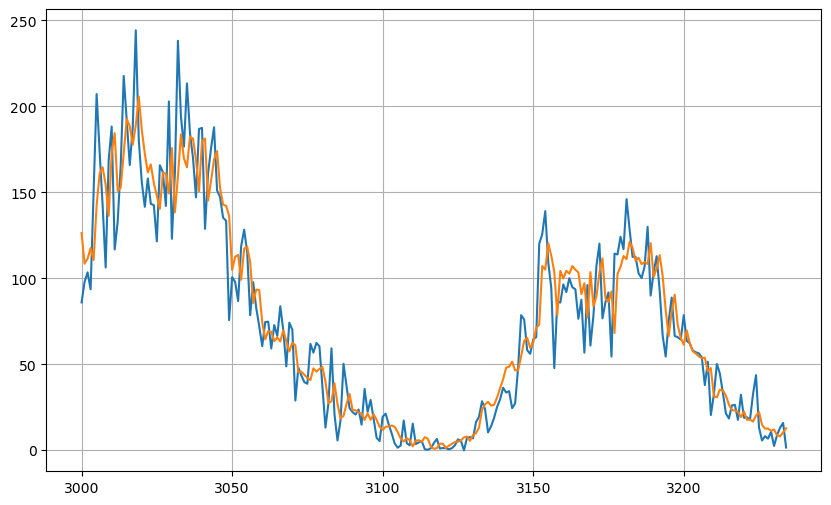

In [51]:
forecast_series = series[split_time-window_size:-1]

# Use helper function to generate predictions
forecast = model_forecast(model, forecast_series, window_size, batch_size)

# Drop single dimensional axis
results = forecast.squeeze()

# Plot the results
plot_series(time_valid, (x_valid, results))

In [52]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

14.20063